In [1]:
import os
import pandas as pd

basel_dataset = pd.read_csv(os.path.join("dataset", "sorted", "BASEL.csv"))
basel_dataset


,DATE,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max
0,20000101,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9
1,20000102,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8
2,20000103,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8
3,20000104,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5
4,20000105,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6
...,...,...,...,...,...,...,...,...,...,...
3649,20091228,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8
3650,20091229,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0
3651,20091230,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5
3652,20091231,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9


In [2]:
import tensorflow as tf
import random
import numpy as np
import os
SEED = 1998
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

TRAIN_END_INDEX = 2922
VALIDATION_END_INDEX = 3288


def get_dataset(
    dataset: pd.DataFrame,
    sequence_length,
    batch_size,
    train_end_index,
    validation_end_index,
):
    data = dataset
    for col in dataset.columns:
        if "temp_mean" in col:
            target = pd.DataFrame(dataset[col])
            data = data.drop(columns=["DATE"])
            break
    train_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data[:-sequence_length],
        targets=target[sequence_length:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=0,
        end_index=train_end_index,
    )
    validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data[:-sequence_length],
        targets=target[sequence_length:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=train_end_index,
        end_index=validation_end_index,
    )
    test_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data[:-sequence_length],
        targets=target[sequence_length:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=validation_end_index,
    )
    return (train_dataset, validation_dataset, test_dataset)

sequence_length = 6
(train_dataset, validation_dataset, test_dataset) = get_dataset(
    basel_dataset, sequence_length, 32, TRAIN_END_INDEX, VALIDATION_END_INDEX
)
print(train_dataset)
for data, label in train_dataset:
    print(data[0])
    print(label[0])
    feature_length = data.shape[2]
    break

2022-11-18 11:11:38.281705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 11:11:38.507043: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 11:11:39.335883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-18 11:11:39.335993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
tf.Tensor(
[[8.     0.89   1.0286 0.2    0.03   0.     2.9    1.6    3.9   ]
 [8.     0.87   1.0318 0.25   0.     0.     3.6    2.7    4.8   ]
 [5.     0.81   1.0314 0.5    0.     3.7    2.2    0.1    4.8   ]
 [7.     0.79   1.0262 0.63   0.35   6.9    3.9    0.5    7.5   ]
 [5.     0.9    1.0246 0.51   0.07   3.7    6.     3.8    8.6   ]
 [3.     0.85   1.0244 0.56   0.     5.7    4.2    1.9    6.9   ]], shape=(6, 9), dtype=float64)
tf.Tensor([4.7], shape=(1,), dtype=float64)


In [3]:
def get_simple_lstm(sequence_length, feature_length):
    model_in = tf.keras.Input((sequence_length, feature_length))
    x = tf.keras.layers.LSTM(16, return_sequences=True)(model_in)
    x = tf.keras.layers.LSTM(16)(x)
    model_out = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])



model = get_simple_lstm(sequence_length, feature_length)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 9)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 16)             1664      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,793
Trainable params: 3,793
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile("rmsprop", "MSE", ["MAE"])

loss: 3.4239 - MAE: 1.4237 - val_loss: 3.2621 - val_MAE: 1.4243
* sequence_length = 4
* lstm 1, unit 16

loss: 3.3885 - MAE: 1.4228 - val_loss: 3.1651 - val_MAE: 1.4173
* sequence_length = 6
* lstm 1, unit 16

loss: 3.5179 - MAE: 1.4533 - val_loss: 3.1334 - val_MAE: 1.4370
* sequence_length = 13
* lstm 1, unit 16

loss: 3.5020 - MAE: 1.4536 - val_loss: 2.9261 - val_MAE: 1.3783
* sequence_length = 6
* lstm 2, unit 16

loss: 3.5265 - MAE: 1.4641 - val_loss: 3.1694 - val_MAE: 1.4177
* sequence_length = 6
* lstm 2, unit 8

loss: 3.3421 - MAE: 1.4192 - val_loss: 3.2702 - val_MAE: 1.4447
* sequence_length = 6
* lstm 3, unit 16



In [5]:
max_epoch = 200
history = model.fit(
    train_dataset,
    epochs=max_epoch,
    validation_data=validation_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ModelCheckpoint("model", save_best_only=True),
    ],
)


Epoch 1/200


2022-11-18 11:11:52.810648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


92/92 [==============================] - ETA: 0s - loss: 125.2273 - MAE: 9.3420

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 18s 102ms/step - loss: 125.2273 - MAE: 9.3420 - val_loss: 87.7894 - val_MAE: 7.6093
Epoch 2/200
90/92 [============================>.] - ETA: 0s - loss: 83.6976 - MAE: 7.4135

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 82.7345 - MAE: 7.3490 - val_loss: 67.1423 - val_MAE: 6.5944
Epoch 3/200
90/92 [============================>.] - ETA: 0s - loss: 66.8518 - MAE: 6.4912

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 66.0837 - MAE: 6.4360 - val_loss: 54.7938 - val_MAE: 5.8844
Epoch 4/200
91/92 [============================>.] - ETA: 0s - loss: 54.5780 - MAE: 5.7842

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 93ms/step - loss: 54.4901 - MAE: 5.7765 - val_loss: 44.9723 - val_MAE: 5.2640
Epoch 5/200
92/92 [==============================] - ETA: 0s - loss: 45.0524 - MAE: 5.1937

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 97ms/step - loss: 45.0524 - MAE: 5.1937 - val_loss: 36.8036 - val_MAE: 4.7197
Epoch 6/200
92/92 [==============================] - ETA: 0s - loss: 37.1143 - MAE: 4.6606

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 99ms/step - loss: 37.1143 - MAE: 4.6606 - val_loss: 29.8927 - val_MAE: 4.2241
Epoch 7/200
90/92 [============================>.] - ETA: 0s - loss: 30.8147 - MAE: 4.2061

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 99ms/step - loss: 30.4845 - MAE: 4.1766 - val_loss: 24.1507 - val_MAE: 3.7684
Epoch 8/200
90/92 [============================>.] - ETA: 0s - loss: 25.2984 - MAE: 3.7703

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 101ms/step - loss: 25.0361 - MAE: 3.7457 - val_loss: 19.5629 - val_MAE: 3.3759
Epoch 9/200
91/92 [============================>.] - ETA: 0s - loss: 20.6538 - MAE: 3.3819

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 20.6258 - MAE: 3.3790 - val_loss: 15.9179 - val_MAE: 3.0497
Epoch 10/200
90/92 [============================>.] - ETA: 0s - loss: 17.2538 - MAE: 3.0841

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 93ms/step - loss: 17.0898 - MAE: 3.0671 - val_loss: 13.0084 - val_MAE: 2.7757
Epoch 11/200
89/92 [============================>.] - ETA: 0s - loss: 14.5291 - MAE: 2.8328

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 95ms/step - loss: 14.2738 - MAE: 2.8048 - val_loss: 10.7276 - val_MAE: 2.5362
Epoch 12/200
89/92 [============================>.] - ETA: 0s - loss: 12.2624 - MAE: 2.6142

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 86ms/step - loss: 12.0586 - MAE: 2.5911 - val_loss: 9.0109 - val_MAE: 2.3328
Epoch 13/200
92/92 [==============================] - ETA: 0s - loss: 10.3316 - MAE: 2.4160

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 93ms/step - loss: 10.3316 - MAE: 2.4160 - val_loss: 7.7533 - val_MAE: 2.1627
Epoch 14/200
91/92 [============================>.] - ETA: 0s - loss: 8.9768 - MAE: 2.2684

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 8.9698 - MAE: 2.2679 - val_loss: 6.7229 - val_MAE: 2.0163
Epoch 15/200
90/92 [============================>.] - ETA: 0s - loss: 7.9519 - MAE: 2.1532

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 7.8970 - MAE: 2.1465 - val_loss: 5.9387 - val_MAE: 1.9016
Epoch 16/200
89/92 [============================>.] - ETA: 0s - loss: 7.1506 - MAE: 2.0545

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 88ms/step - loss: 7.0624 - MAE: 2.0436 - val_loss: 5.3699 - val_MAE: 1.8220
Epoch 17/200
90/92 [============================>.] - ETA: 0s - loss: 6.4622 - MAE: 1.9661

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 102ms/step - loss: 6.4250 - MAE: 1.9615 - val_loss: 4.9710 - val_MAE: 1.7733
Epoch 18/200
92/92 [==============================] - ETA: 0s - loss: 5.9423 - MAE: 1.8980

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 5.9423 - MAE: 1.8980 - val_loss: 4.6834 - val_MAE: 1.7366
Epoch 19/200
91/92 [============================>.] - ETA: 0s - loss: 5.5751 - MAE: 1.8457

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 5.5732 - MAE: 1.8459 - val_loss: 4.4814 - val_MAE: 1.7094
Epoch 20/200
91/92 [============================>.] - ETA: 0s - loss: 5.2883 - MAE: 1.8026

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 85ms/step - loss: 5.2867 - MAE: 1.8028 - val_loss: 4.3340 - val_MAE: 1.6871
Epoch 21/200
89/92 [============================>.] - ETA: 0s - loss: 5.1066 - MAE: 1.7726

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 90ms/step - loss: 5.0635 - MAE: 1.7664 - val_loss: 4.2193 - val_MAE: 1.6688
Epoch 22/200
92/92 [==============================] - ETA: 0s - loss: 4.8871 - MAE: 1.7365

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 4.8871 - MAE: 1.7365 - val_loss: 4.1269 - val_MAE: 1.6507
Epoch 23/200
92/92 [==============================] - ETA: 0s - loss: 4.7464 - MAE: 1.7114

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 91ms/step - loss: 4.7464 - MAE: 1.7114 - val_loss: 4.0501 - val_MAE: 1.6359
Epoch 24/200
90/92 [============================>.] - ETA: 0s - loss: 4.6490 - MAE: 1.6923

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 86ms/step - loss: 4.6338 - MAE: 1.6901 - val_loss: 3.9914 - val_MAE: 1.6241
Epoch 25/200
89/92 [============================>.] - ETA: 0s - loss: 4.5760 - MAE: 1.6778

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 91ms/step - loss: 4.5441 - MAE: 1.6729 - val_loss: 3.9478 - val_MAE: 1.6138
Epoch 26/200
90/92 [============================>.] - ETA: 0s - loss: 4.4859 - MAE: 1.6605

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 4.4721 - MAE: 1.6585 - val_loss: 3.9154 - val_MAE: 1.6068
Epoch 27/200
91/92 [============================>.] - ETA: 0s - loss: 4.4149 - MAE: 1.6466

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 88ms/step - loss: 4.4134 - MAE: 1.6467 - val_loss: 3.8908 - val_MAE: 1.6022
Epoch 28/200
91/92 [============================>.] - ETA: 0s - loss: 4.3661 - MAE: 1.6366

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 82ms/step - loss: 4.3646 - MAE: 1.6367 - val_loss: 3.8719 - val_MAE: 1.5981
Epoch 29/200
92/92 [==============================] - ETA: 0s - loss: 4.3229 - MAE: 1.6281

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 92ms/step - loss: 4.3229 - MAE: 1.6281 - val_loss: 3.8566 - val_MAE: 1.5942
Epoch 30/200
91/92 [============================>.] - ETA: 0s - loss: 4.2878 - MAE: 1.6203

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 92ms/step - loss: 4.2860 - MAE: 1.6204 - val_loss: 3.8424 - val_MAE: 1.5899
Epoch 31/200
90/92 [============================>.] - ETA: 0s - loss: 4.2642 - MAE: 1.6154

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 91ms/step - loss: 4.2519 - MAE: 1.6136 - val_loss: 3.8254 - val_MAE: 1.5846
Epoch 32/200
91/92 [============================>.] - ETA: 0s - loss: 4.2214 - MAE: 1.6070

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 85ms/step - loss: 4.2195 - MAE: 1.6070 - val_loss: 3.8049 - val_MAE: 1.5791
Epoch 33/200
92/92 [==============================] - ETA: 0s - loss: 4.1893 - MAE: 1.6005

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 92ms/step - loss: 4.1893 - MAE: 1.6005 - val_loss: 3.7848 - val_MAE: 1.5737
Epoch 34/200
89/92 [============================>.] - ETA: 0s - loss: 4.1861 - MAE: 1.5984

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 91ms/step - loss: 4.1618 - MAE: 1.5945 - val_loss: 3.7666 - val_MAE: 1.5688
Epoch 35/200
91/92 [============================>.] - ETA: 0s - loss: 4.1392 - MAE: 1.5889

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 4.1370 - MAE: 1.5888 - val_loss: 3.7492 - val_MAE: 1.5640
Epoch 36/200
92/92 [==============================] - ETA: 0s - loss: 4.1142 - MAE: 1.5836

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 4.1142 - MAE: 1.5836 - val_loss: 3.7313 - val_MAE: 1.5596
Epoch 37/200
90/92 [============================>.] - ETA: 0s - loss: 4.1042 - MAE: 1.5804

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 4.0931 - MAE: 1.5787 - val_loss: 3.7133 - val_MAE: 1.5553
Epoch 38/200
90/92 [============================>.] - ETA: 0s - loss: 4.0843 - MAE: 1.5758

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 86ms/step - loss: 4.0733 - MAE: 1.5740 - val_loss: 3.6956 - val_MAE: 1.5511
Epoch 39/200
92/92 [==============================] - ETA: 0s - loss: 4.0546 - MAE: 1.5698

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 102ms/step - loss: 4.0546 - MAE: 1.5698 - val_loss: 3.6792 - val_MAE: 1.5470
Epoch 40/200
92/92 [==============================] - ETA: 0s - loss: 4.0367 - MAE: 1.5658

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 92ms/step - loss: 4.0367 - MAE: 1.5658 - val_loss: 3.6658 - val_MAE: 1.5435
Epoch 41/200
92/92 [==============================] - ETA: 0s - loss: 4.0194 - MAE: 1.5620

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 92ms/step - loss: 4.0194 - MAE: 1.5620 - val_loss: 3.6551 - val_MAE: 1.5412
Epoch 42/200
92/92 [==============================] - ETA: 0s - loss: 4.0025 - MAE: 1.5585

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 88ms/step - loss: 4.0025 - MAE: 1.5585 - val_loss: 3.6459 - val_MAE: 1.5397
Epoch 43/200
92/92 [==============================] - ETA: 0s - loss: 3.9863 - MAE: 1.5552

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 100ms/step - loss: 3.9863 - MAE: 1.5552 - val_loss: 3.6380 - val_MAE: 1.5385
Epoch 44/200
91/92 [============================>.] - ETA: 0s - loss: 3.9731 - MAE: 1.5523

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 92ms/step - loss: 3.9704 - MAE: 1.5520 - val_loss: 3.6308 - val_MAE: 1.5371
Epoch 45/200
91/92 [============================>.] - ETA: 0s - loss: 3.9574 - MAE: 1.5492

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 96ms/step - loss: 3.9547 - MAE: 1.5489 - val_loss: 3.6247 - val_MAE: 1.5359
Epoch 46/200
90/92 [============================>.] - ETA: 0s - loss: 3.9489 - MAE: 1.5479

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 93ms/step - loss: 3.9389 - MAE: 1.5460 - val_loss: 3.6190 - val_MAE: 1.5348
Epoch 47/200
91/92 [============================>.] - ETA: 0s - loss: 3.9259 - MAE: 1.5435

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 97ms/step - loss: 3.9231 - MAE: 1.5432 - val_loss: 3.6149 - val_MAE: 1.5340
Epoch 48/200
90/92 [============================>.] - ETA: 0s - loss: 3.9167 - MAE: 1.5422

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 88ms/step - loss: 3.9069 - MAE: 1.5404 - val_loss: 3.6114 - val_MAE: 1.5337
Epoch 49/200
91/92 [============================>.] - ETA: 0s - loss: 3.8935 - MAE: 1.5378

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 96ms/step - loss: 3.8907 - MAE: 1.5375 - val_loss: 3.6098 - val_MAE: 1.5337
Epoch 50/200
91/92 [============================>.] - ETA: 0s - loss: 3.8770 - MAE: 1.5348

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 94ms/step - loss: 3.8742 - MAE: 1.5345 - val_loss: 3.6073 - val_MAE: 1.5337
Epoch 51/200
91/92 [============================>.] - ETA: 0s - loss: 3.8602 - MAE: 1.5317

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 96ms/step - loss: 3.8574 - MAE: 1.5314 - val_loss: 3.6058 - val_MAE: 1.5338
Epoch 52/200
92/92 [==============================] - ETA: 0s - loss: 3.8406 - MAE: 1.5283

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 3.8406 - MAE: 1.5283 - val_loss: 3.6024 - val_MAE: 1.5336
Epoch 53/200
92/92 [==============================] - ETA: 0s - loss: 3.8233 - MAE: 1.5251

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 9s 97ms/step - loss: 3.8233 - MAE: 1.5251 - val_loss: 3.5996 - val_MAE: 1.5329
Epoch 54/200
90/92 [============================>.] - ETA: 0s - loss: 3.8159 - MAE: 1.5239

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 91ms/step - loss: 3.8064 - MAE: 1.5220 - val_loss: 3.5966 - val_MAE: 1.5323
Epoch 55/200
91/92 [============================>.] - ETA: 0s - loss: 3.7921 - MAE: 1.5190

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 89ms/step - loss: 3.7892 - MAE: 1.5187 - val_loss: 3.5942 - val_MAE: 1.5314
Epoch 56/200
92/92 [==============================] - ETA: 0s - loss: 3.7731 - MAE: 1.5155

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 83ms/step - loss: 3.7731 - MAE: 1.5155 - val_loss: 3.5931 - val_MAE: 1.5317
Epoch 57/200
90/92 [============================>.] - ETA: 0s - loss: 3.7665 - MAE: 1.5140

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


92/92 [==============================] - 8s 90ms/step - loss: 3.7569 - MAE: 1.5122 - val_loss: 3.5923 - val_MAE: 1.5315
Epoch 58/200
92/92 [==============================] - 2s 19ms/step - loss: 3.7418 - MAE: 1.5090 - val_loss: 3.5929 - val_MAE: 1.5325
Epoch 59/200
92/92 [==============================] - 2s 19ms/step - loss: 3.7266 - MAE: 1.5057 - val_loss: 3.5935 - val_MAE: 1.5326
Epoch 60/200
92/92 [==============================] - 2s 19ms/step - loss: 3.7124 - MAE: 1.5028 - val_loss: 3.5954 - val_MAE: 1.5338
Epoch 61/200
92/92 [==============================] - 2s 19ms/step - loss: 3.6979 - MAE: 1.4999 - val_loss: 3.5979 - val_MAE: 1.5342
Epoch 62/200
92/92 [==============================] - 2s 19ms/step - loss: 3.6845 - MAE: 1.4973 - val_loss: 3.6009 - val_MAE: 1.5357


Text(0, 0.5, 'MSE')

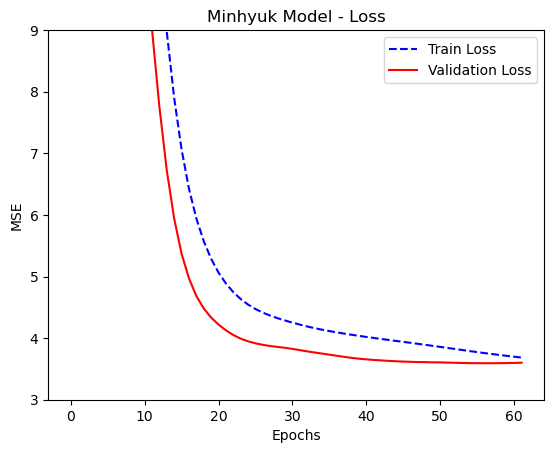

In [28]:
import matplotlib.pyplot as plt
epochs = len(history.history["loss"])
plt.plot(range(epochs), history.history["loss"], "b--", label="Train Loss")
plt.plot(range(epochs), history.history["val_loss"], "r", label="Validation Loss")
plt.ylim(3, 9)
plt.title("Minhyuk Model - Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")

Text(0.5, 1.0, 'Minhyuk Model - MAE')

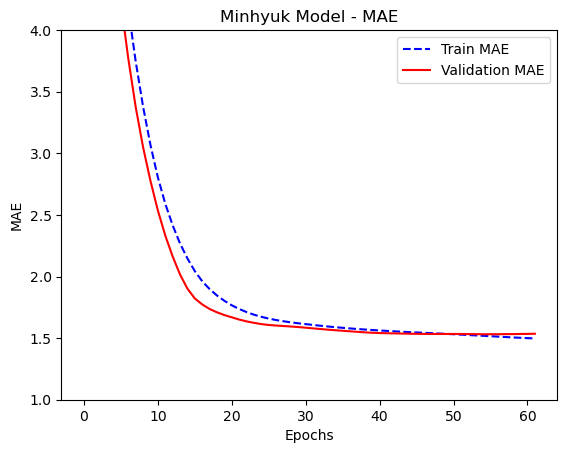

In [27]:
epochs = len(history.history["MAE"])
plt.plot(range(epochs), history.history["MAE"], "b--", label="Train MAE")
plt.plot(range(epochs), history.history["val_MAE"], "r", label="Validation MAE")
plt.ylim(1, 4)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Minhyuk Model - MAE")

12/12 [==============================] - 1s 6ms/step


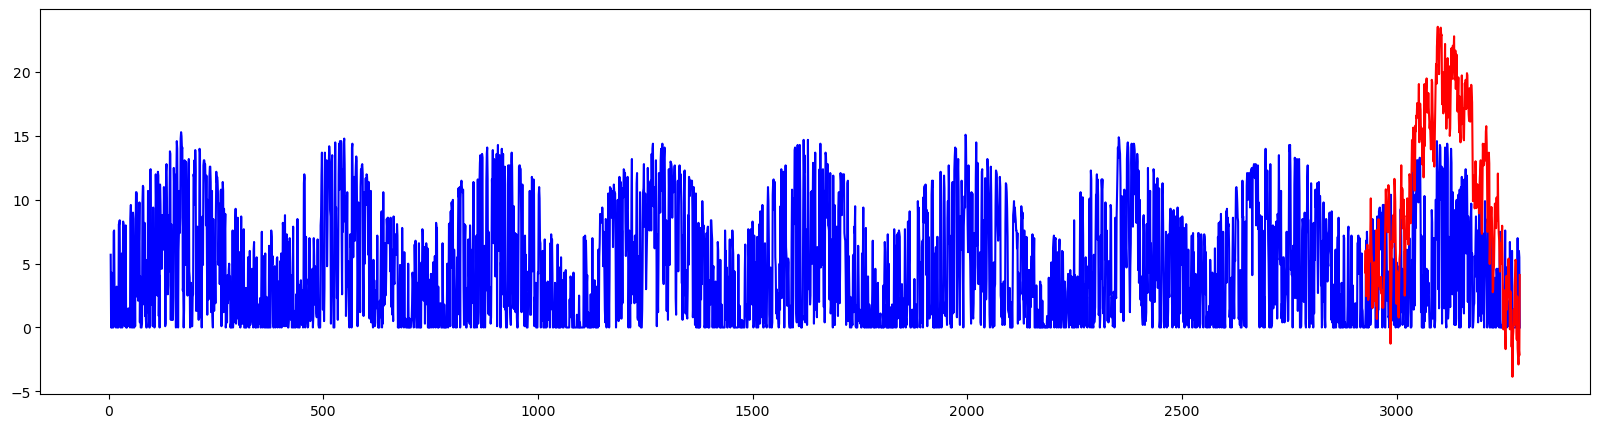

In [8]:
val_predictions = model.predict(validation_dataset)
import numpy as np
plt.figure(figsize=(20, 5))
plt.plot(
    range(sequence_length-1, VALIDATION_END_INDEX),
    basel_dataset.iloc[sequence_length-1 : VALIDATION_END_INDEX, 6],
    "b",
)
plt.plot(range(TRAIN_END_INDEX+sequence_length-1, VALIDATION_END_INDEX), val_predictions[:, 0], "r")
plt.show()


In [9]:
predictions = model.predict(validation_dataset)
predictions.shape


12/12 [==============================] - 0s 7ms/step


(361, 1)

In [10]:
for i in range(len(basel_dataset.index)):
    if "2008" in str(basel_dataset.iloc[i, 0]):
        print(i)
        break


2922


In [11]:
basel_dataset[2921:]


,DATE,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max
2921,20071231,6,0.86,1.0311,0.49,0.00,1.3,0.9,-2.4,4.9
2922,20080101,8,0.86,1.0257,0.22,0.00,0.0,-0.5,-2.2,0.9
2923,20080102,8,0.67,1.0181,0.25,0.00,0.0,-1.4,-2.1,-0.8
2924,20080103,7,0.68,1.0076,0.28,0.00,0.1,-0.5,-3.1,3.2
2925,20080104,8,0.80,1.0131,0.14,0.00,0.0,-0.3,-3.6,2.3
...,...,...,...,...,...,...,...,...,...,...
3649,20091228,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8
3650,20091229,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0
3651,20091230,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5
3652,20091231,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9


In [12]:
import numpy as np


def evaluate_naive_method(dataset):
    total_abs_err = 0
    data_seen = 0
    train_std = basel_dataset["BASEL_temp_mean"].std()
    train_mean = basel_dataset["BASEL_temp_mean"].mean()
    for data, label in dataset:
        preds = data[:, -1, 6] * train_std + train_mean
        total_abs_err += np.sum(np.abs(preds - label))
        data_seen += data.shape[0]
    return total_abs_err / data_seen


print("Navie Method Validation MAE:", evaluate_naive_method(validation_dataset))


Navie Method Validation MAE: 2595.4648983964335


In [13]:
for data, label in validation_dataset:
    print(data.shape)


(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(32, 6, 9)
(9, 6, 9)
